In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_lenta
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [2]:
dataset = fetch_lenta()
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils._bunch.Bunch'>

Dataset features shape: (687029, 193)
Dataset target shape: (687029,)
Dataset treatment shape: (687029,)


In [9]:
norm_columns = ['age', 'children', 'gender', 'main_format', 'months_from_register', 'response_sms', 'response_viber']

In [10]:
dataset.data[norm_columns].head()

,age,children,gender,main_format,months_from_register,response_sms,response_viber
0,47.0,0.0,Ж,0,18.0,0.923077,0.071429
1,57.0,0.0,Ж,1,4.0,1.000000,0.000000
2,38.0,3.0,М,0,34.0,1.000000,0.250000
3,65.0,0.0,Ж,1,40.0,0.909091,0.000000
4,61.0,2.0,Ж,0,20.0,1.000000,0.100000


In [17]:
dataset.data['children'].value_counts()

0.0    416983
1.0    126636
2.0    109892
3.0     24257
4.0       530
5.0        91
6.0        46
7.0         9
9.0         2
8.0         2
Name: children, dtype: int64

In [11]:
treat_dict = {
    'test': 1,
    'control': 0
}

dataset.treatment = dataset.treatment.map(treat_dict)

In [12]:
dataset.data['gender'] = dataset.data['gender'].fillna(value='Не определен')

print(dataset.data['gender'].value_counts(dropna=False))

Ж               433448
М               243910
Не определен      9671
Name: gender, dtype: int64


In [13]:
stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (480920, 193)
Validation shape: (206109, 193)


In [24]:
X_val.head()

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
89820,36.0,2.0,3.0,1.0,1.0,12.0,13.0,2.0,2.0,18.0,...,932.78,0.00,47.88,0.00,145.87,470.92,38.99,0.0,NaN,0.1969
539582,34.0,16.0,52.0,17.0,66.0,59.0,30.0,9.0,32.0,53.0,...,3308.32,82.07,1541.52,1248.53,633.48,1841.38,186.73,0.0,NaN,0.2559
237165,39.0,0.0,0.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,...,105.79,214.92,22.99,39.98,172.99,139.64,69.57,0.0,0.0,NaN
653847,26.0,3.0,4.0,5.0,0.0,3.0,3.0,1.0,2.0,3.0,...,0.00,0.00,0.00,0.00,0.00,0.00,86.52,0.0,0.0,0.0000
94205,46.0,0.0,7.0,11.0,5.0,1.0,6.0,0.0,6.0,0.0,...,1513.76,1618.35,233.89,471.20,394.21,1384.44,402.20,0.0,0.0,NaN


In [27]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

## Single model

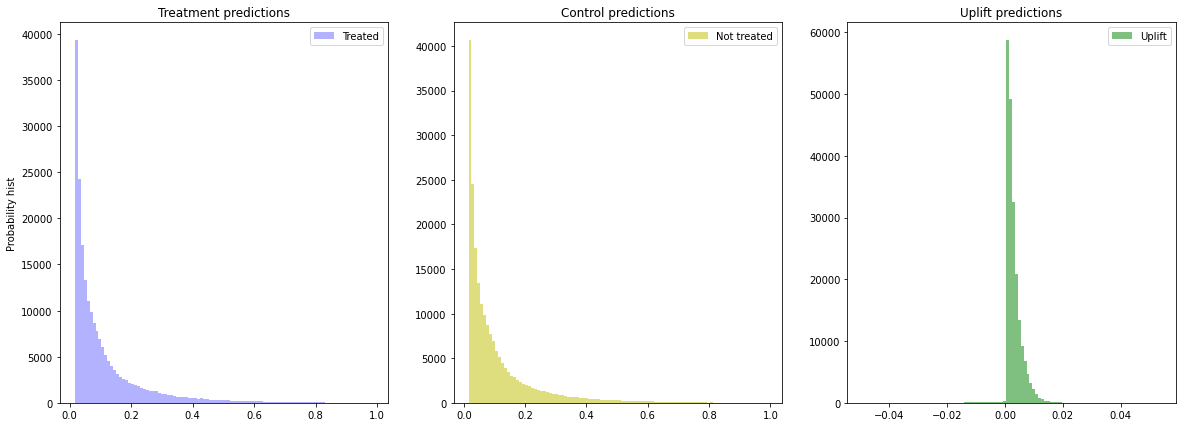

In [30]:
sm = SoloModel(CatBoostClassifier(iterations=1000, task_type="GPU", random_state=42, silent=True))
sm = sm.fit(X_train, y_train, trmnt_train, estimator_fit_params={'cat_features': ['gender']})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [31]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,k_var_days_between_visits_3m,10.261643
1,k_var_days_between_visits_15d,5.330679
2,food_share_1m,4.544786
3,cheque_count_12m_g48,4.329268
4,perdelta_days_between_visits_15_30d,4.319264
...,...,...
189,k_var_count_per_cheque_6m_g32,0.023904
190,sale_sum_12m_g54,0.023079
191,sale_count_6m_g44,0.017349
192,sale_count_6m_g57,0.009368


## Class transform

In [33]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True))
ct = ct.fit(X_train, y_train, trmnt_train, estimator_fit_params={'cat_features': ['gender']})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

## Two independent models

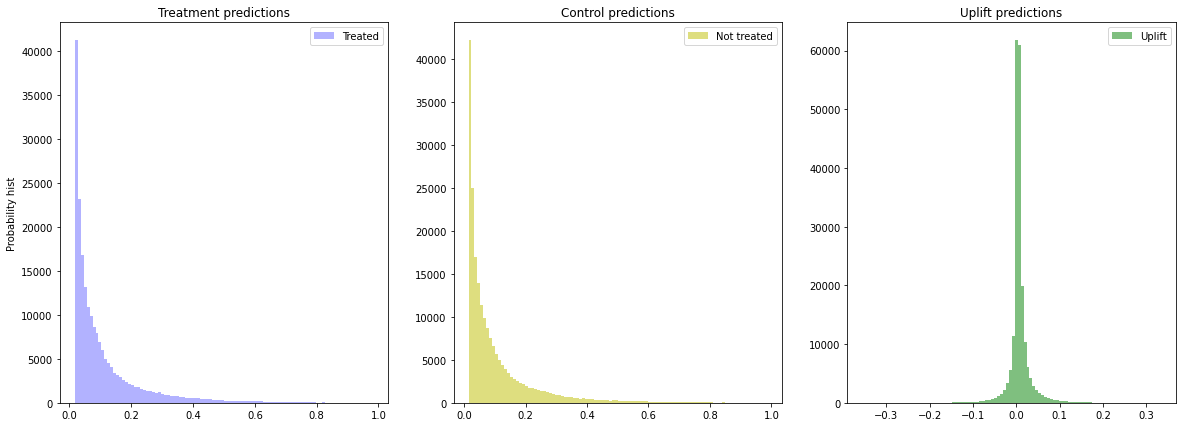

In [35]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, trmnt_train,
    estimator_trmnt_fit_params={'cat_features': ['gender']},
    estimator_ctrl_fit_params={'cat_features': ['gender']}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

## Two dependend models

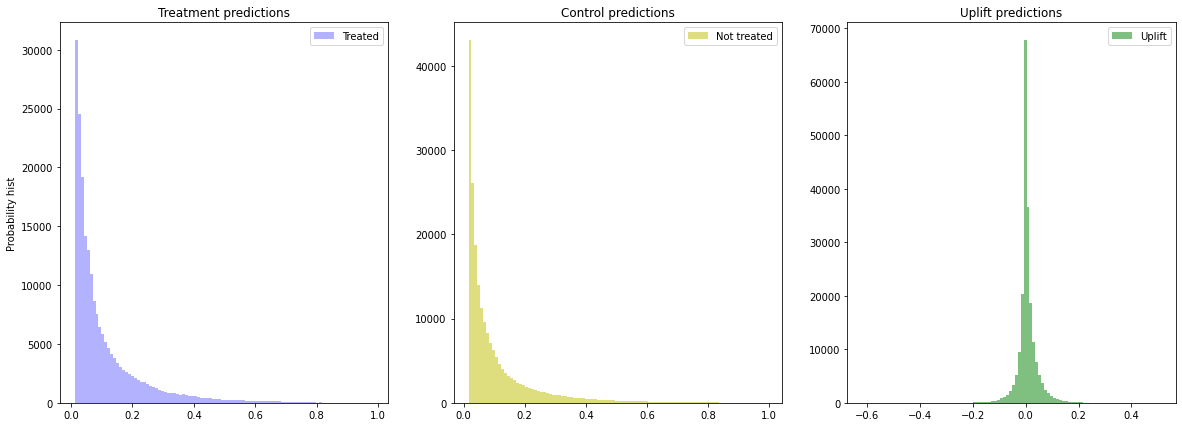

In [36]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True),
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, trmnt_train,
    estimator_trmnt_fit_params={'cat_features': ['gender']},
    estimator_ctrl_fit_params={'cat_features': ['gender']}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

In [47]:
pd.DataFrame([tm_ctrl.trmnt_preds_, uplift_tm_ctrl])

,0,1,2,3,4,5,6,7,8,9,...,206099,206100,206101,206102,206103,206104,206105,206106,206107,206108
0,0.116088,0.269822,0.049340,0.038516,0.143292,0.047044,0.018165,0.086771,0.137409,0.029504,...,0.191889,0.044686,0.069574,0.170429,0.384708,0.022230,0.020183,0.043997,0.283808,0.053526
1,0.045442,0.041342,-0.018277,0.012866,0.028861,0.007020,-0.001542,0.047911,-0.013122,-0.004837,...,0.076940,-0.005309,0.033985,-0.097014,-0.093607,0.002797,0.000479,0.014596,-0.098411,0.024334


## Results

In [37]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
3,ClassTransformation,0.031702
4,TwoModels,0.016004
1,SoloModel,0.013953
2,SoloModel,0.013411
5,TwoModels_ddr_control,0.011537
0,SoloModel,0.006042


C:\Users\HardWorkingStation\PyProjects\uplift_lab\venv\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


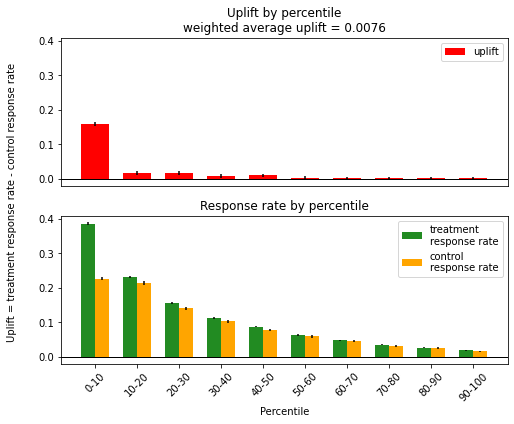

In [39]:
from sklift.viz import plot_uplift_by_percentile

# line plot
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='bar');

In [48]:
type(dataset)

sklearn.utils._bunch.Bunch